### Note: I implemented this solution suing python 3.11.9 version

#### Importing required modules

In [7]:
# Import the required modules
import os
import json
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END
import requests
from typing import List, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_openai import AzureChatOpenAI
from openai import AzureOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.schema import HumanMessage, AIMessage
import yfinance as yf


#### Loading credentials from .env file

#####  we required Azure openai - gpt-4o-mini model credentials
##### Weather api key : https://www.weatherapi.com/
##### Taviliy API key : https://tavily.com/


##### Note : create an .env file and provide your credentials

In [8]:

# Load environment variables
load_dotenv()

# Retrieve credentials
WEATHER_API_KEY = os.environ['WEATHER_API_KEY']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']

openai_api_version = os.getenv("OPENAI_API_VERSION")
azure_openai_endpoint = os.getenv("ENDPOINT_URL_MINI")
azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY_MINI")
deployment_name = os.getenv('DEPLOYMENT_NAME_MINI')

if not os.environ.get("AZURE_OPENAI_API_KEY"):
    os.environ["AZURE_OPENAI_API_KEY"] = azure_openai_api_key



#### LLM (gpt-4o-mini) intialization

In [9]:


## LLM (gpt-4o-mini) intialization

llm = AzureChatOpenAI(
    azure_endpoint=azure_openai_endpoint,
    azure_deployment=deployment_name,
    openai_api_version=openai_api_version,
)


client = AzureOpenAI(
    azure_endpoint=azure_openai_endpoint,
    api_key=azure_openai_api_key,
    api_version=openai_api_version,
)



#### Initialize persistent memory, and memory for saving chat, and loading past history

In [10]:
# Initialize persistent memory
memory_file = "conversation_memory.json"
memory = ConversationBufferMemory()




# Load previous conversation history
if os.path.exists(memory_file):
    try:
        with open(memory_file, "r") as f:
            saved_messages = json.load(f)
            for msg_data in saved_messages:
                if msg_data["type"] == "human":
                    memory.chat_memory.add_user_message(msg_data["content"])
                elif msg_data["type"] == "ai":
                    memory.chat_memory.add_ai_message(msg_data["content"])
        print("\nLoaded previous conversation history.")
    except Exception as e:
        print(f"\nError loading memory: {e}")




Loaded previous conversation history.


#### function for getting symbol ticker for yfinanace library 

In [11]:



## function for getting symbol ticker for yfinanace library
def finance(client, query):
    prompt = f"""You are a financial advisor. Your task is to analyze the given query, identify the company or stock mentioned, and convert it into its corresponding ticker symbol (used in the yfinance Python library).  

## Given Query: {query}  

### Examples:  
#### Input:  
"I want to check the latest stock price of Apple."  
#### Output:  
{{"symbol": "AAPL"}}  

#### Input:  
"Tell me about Tesla's stock performance."  
#### Output:  
{{"symbol": "TSLA"}}  

#### Input:  
"How is Microsoft's stock doing today?"  
#### Output:  
{{"symbol": "MSFT"}}  

Ensure you return only the JSON output in the specified format. If the company or stock is unknown, respond with:  
{{"symbol": "your converted symbol will be here"}}  
"""  

    messages = [
        {"role": "system", "content": "You are a helpful assistant that outputs in json"},
        {"role": "user", "content": prompt},
    ]
    stream = client.chat.completions.create(
        model=deployment_name,
        messages=messages,
        max_tokens=200,
        temperature=0.2,
    )
    res=stream.choices[0].message.content
    res=json.loads(res)
    return res['symbol']



#### Function for Intent (weather/news/finance/sentiment/translation/general query) and entity detection

In [12]:

## Function for Intent and entity detection
def detect_intent(query: str) -> dict:
    """Detect intent using Azure OpenAI"""
    response = client.chat.completions.create(
        model=deployment_name,
        messages=[{
            "role": "user",
            "content": f"""Analyze this query and output JSON:
            Query: {query}
            Output format: {{
                "intent": "weather/news/finance/sentiment/translation/general",
                "entities": {{
                    "locations": [],
                    "keywords": [],
                    "companies": []
                }}
            }}"""
        }],
        temperature=0.2
    )

    res=response.choices[0].message.content
    res=json.loads(res)
    return res




#### function for routing queries to their corrospond route or agent node or tools

In [13]:

## function for routing queries to their corrospond route
def route_query(query: str) -> str:
    """Enhanced routing with memory context"""
    intent_data = detect_intent(query)
    
    if intent_data["intent"] == "weather":
        return get_weather(intent_data["entities"]["locations"][0])
    elif intent_data["intent"] == "news":
        return get_news(" ".join(intent_data["entities"]["keywords"]))
    elif intent_data["intent"] == "finance":
        return get_financial_data(intent_data["entities"]["companies"][0])
    elif intent_data["intent"] == "translation":
        return translate_text(query)
    elif intent_data["intent"] == "sentiment":
        return analyze_sentiment(query)
    else:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[{"role": "user", "content": query}],
            temperature=0.7
        )
        return response.choices[0].message.content



#### Defining tools 
##### tool 1: fetching weather data : using weather api
##### tool 2: tool for fetching news from web search : tavily search api
##### tool 3: tool for translation 
##### tool 4: tool for sentiment analysis
##### tool 5: tool for getting financial data : yfinanace libraary


In [14]:



# tool 1: fetching weather data
@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather"""
    endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
    response = requests.get(endpoint)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"
    

# tool 2: tool for fetching news from web search
@tool
def get_news(query: str) -> str:
    """
    Search the web for news articles related to the query and return the top results with citation links.
    
    Args:
        query (str): The search query for news articles.
    
    Returns:
        str: A formatted string containing the top news results with titles, snippets, and citation links.
    """
    # Initialize TavilySearchResults
    tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=4, search_depth='advanced', max_tokens=1000)
    
    # Fetch search results
    results = tavily_search.invoke(query)
    
    # Format the results with titles, snippets, and URLs
    formatted_results = []
    for result in results:
        title = result.get("title", "No Title")
        snippet = result.get("content", "No Snippet Available")
        url = result.get("url", "No URL Available")
        
        # Format each result
        formatted_result = f"**Title:** {title}\n**Snippet:** {snippet}\n**Link:** {url}\n"
        formatted_results.append(formatted_result)
    
    # Combine all results into a single string
    return "\n\n".join(formatted_results)


# tool 3: tool for translation
@tool
def translate_text(query: str) -> str:
    """Translates the given query text into the target language."""
    prompt = f'''You are an efficient translator. First, analyze the query and its language, then translate it to the target language.
    ## Given Query: {query}
    Note: In the output, only provide the translation of the query, nothing else.
    ## Desired Output:
    translated text: "your translated text will be here"
    Ensure you follow the output format.
    '''
    messages = [
        {"role": "system", "content": "You are a helpful assistant that translates the given sentence."},
        {"role": "user", "content": prompt},
    ]
    stream = client.chat.completions.create(
        model=deployment_name,
        messages=messages,
        max_tokens=200,
        temperature=0.2,
    )
    return stream.choices[0].message.content



# tool 4: tool for sentiment analysis
@tool
def analyze_sentiment(query: str) -> str:
    """Performs sentiment analysis on the provided query."""
    prompt = f'''
    You are a sentiment analyzer. First, analyze the sentiment of the given query and detect its language. Then, provide the sentiment analysis result.
    ## Given Query: {query}
    Note: In the output, only provide the sentiment result, nothing else.
    '''
    messages = [
        {"role": "system", "content": "You are a helpful assistant that performs sentiment analysis."},
        {"role": "user", "content": prompt},
    ]
    stream = client.chat.completions.create(
        model=deployment_name,
        messages=messages,
        max_tokens=200,
        temperature=0.2,
    )
    return stream.choices[0].message.content



# tool 5: tool for getting financial data
@tool
def get_financial_data(query: str) -> str:
    """Simulates fetching financial data for a given query."""
    # Simulate financial data retrieval
    ticker_symbol=finance(client, query)
    # Define the stock ticker symbol


    # Fetch the stock data
    stock = yf.Ticker(ticker_symbol)

    # Get the current price
    current_price = stock.history(period="1d")['Close'].iloc[-1]

    return f"Current Price of {ticker_symbol}: {current_price}"



#### Tool binding and tool node initialization

In [15]:


# Configure LangGraph workflow
tools = [get_weather, get_news, translate_text, analyze_sentiment, get_financial_data]
llm_with_tools = llm.bind_tools(tools)


# Configure StateGraph
tool_node = ToolNode(tools)


#### Function for calling LLM and Tools 
These are the nodes for workflow

In [16]:


## function for calling llm
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


## function for calling Tools 
def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    check_tool = last_message.tool_calls
    if check_tool:
        # print("\n")
        print("Triggered Tool or Agent:", check_tool[0]['name'])
        return "tools"
    return END


#### function for checking exact query from history

In [17]:

## function for checking exact query from history
def check_history(query: str) -> str | None:
    """Check for exact query matches in history"""
    history = memory.load_memory_variables({})['history']
    messages = memory.chat_memory.messages
    
    for i in range(0, len(messages), 2):
        if i+1 >= len(messages):
            break
        if isinstance(messages[i], HumanMessage) and messages[i].content == query:
            return messages[i+1].content  # Return next message (AI response)
    return None



#### Langgraph workflow design adding nodes and edges

In [18]:


## workflow design adding nodes and edges

workflow = StateGraph(MessagesState)
workflow.add_node("LLM", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "LLM")
workflow.add_conditional_edges("LLM", call_tools)
workflow.add_edge("tools", "LLM")
agent = workflow.compile()




#### displaying langraph agentic workflow

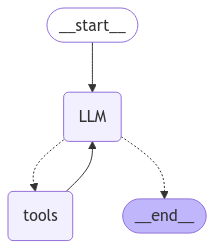

In [19]:


from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



#### Inferencing on some query samples and saving chat history to persistent memory-
##### See the output : it shows the query, related function called and response.

In [55]:


try:
    while True:
        query = input("\nYou: ")
        print("User Query:", query)
        if query.lower() in ['exit', 'quit']:
            print("You terminated the conversation")
            break
        
        # Check for existing response in history
        cached_response = check_history(query)
        if cached_response:
            print(f"\nResponse (cached): {cached_response}")
            print("\n\n")
            continue
            
        # Rest of original processing flow
        memory.chat_memory.add_user_message(query)
        messages = []
        for msg in memory.chat_memory.messages:
            role = "user" if isinstance(msg, HumanMessage) else "assistant"
            messages.append((role, msg.content))
        
        response = agent.invoke({"messages": messages})
        ai_response = response["messages"][-1].content
        
        memory.chat_memory.add_ai_message(ai_response)
        print(f"\nResponse: {ai_response}")
        print("\n\n")

finally:
    # Save conversation history
    try:
        with open(memory_file, "w") as f:
            history = [{
                "type": "human" if isinstance(msg, HumanMessage) else "ai",
                "content": msg.content
            } for msg in memory.chat_memory.messages]
            json.dump(history, f, indent=2)
        print("\nConversation history saved successfully.")
    except Exception as e:
        print(f"\nError saving memory: {e}")

User Query: will rain in jaipur tonight?
Triggered Tool or Agent: get_weather

Response: Tonight in Jaipur, the weather is expected to be clear and sunny with a temperature around 23.2°C (73.8°F). There is no indication of rain, as the precipitation level is currently at 0.0 mm.



User Query: How is Bitcoin performing today?
Triggered Tool or Agent: get_financial_data

Response: Today, Bitcoin is currently priced at $98,606.48.



User Query: what about TCS NSE
Triggered Tool or Agent: get_financial_data

Response: The current price of TCS (Tata Consultancy Services) on the NSE is ₹4,091.10.



User Query: latest news on Delhi election
Triggered Tool or Agent: get_news

Response: Here are the latest news articles related to the Delhi election:

1. **Delhi Elections 2025 LIVE**: Delhi is set for an intense triangular contest between the Bharatiya Janata Party, the Aam Aadmi Party, and the Congress to elect its Chief Minister for the next five years. Voting will take place across 13,766